In [1]:
import tensorflow as tf
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from keras.layers import Input, Dense, GlobalAveragePooling2D, UpSampling2D, add, concatenate, Conv2D, Lambda, BatchNormalization, LeakyReLU, MaxPool2D, LSTM, GRU

In [2]:
df = pd.read_csv("dataframe.csv", header = 0, index_col=0)

In [3]:
df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
565,25,-1,1,12,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/1...,1,623,54,6,272,240,accident
556,25,-1,1,2,29,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/7...,0,624,42,6,278,240,accident
557,25,-1,1,3,6,signschool,test,https://signstock.blob.core.windows.net/signsc...,1,625,675,50,1461,1080,accident
560,25,-1,1,6,6,signschool,train,https://signstock.blob.core.windows.net/signsc...,1,628,677,98,1386,1080,accident
561,25,-1,1,7,13,asldeafined,train,https://media.asldeafined.com/vocabulary/14661...,0,629,69,23,613,480,accident
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,25,-1,1,1,115,aslbrick,train,http://aslbricks.org/New/ASL-Videos/tiger.mp4,0,69510,331,34,1000,720,tiger
537,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/white.mp4,0,69533,366,40,875,720,white
78,25,-1,1,1,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/who.mp4,0,69534,381,45,868,720,who
1331,25,-1,1,1,115,aslbrick,test,http://aslbricks.org/New/ASL-Videos/write.mp4,0,69544,375,42,940,720,write


In [4]:
X = joblib.load(open("features.pkl", "rb"))

## Prepare dataset

In [5]:
encoder = pickle.load(open("reduced one hot encoder", 'rb'))
y = encoder.transform(np.array(list(df["gloss"])).reshape(-1,1)).toarray()

In [6]:
le = pickle.load(open("reduced label encoder", 'rb'))
y_ = le.transform(np.array(list(df["gloss"])))

In [7]:
y_.shape

(642,)

In [8]:
print(X.shape, y.shape)

(642, 64, 520, 3) (642, 100)


In [9]:
input_dim = X.shape[1:]
nb_classes = y.shape[-1]

## Model implementation

In [10]:
model = Sequential()
model.add(Input(shape=(input_dim)))
model.add(Conv2D(filters=8, kernel_size= 3, strides = (1, 2), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(input_dim[0], 3), strides = (1, 2), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size= 3, strides = (1, 2),padding='same', activation='relu'))
model.add(tf.keras.layers.Reshape((64, 65*32)))
model.add(GRU(64))
# model.add(Dense(128, activation='relu'))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 260, 8)        224       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 130, 16)       24592     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 65, 32)        4640      
                                                                 
 reshape (Reshape)           (None, 64, 2080)          0         
                                                                 
 gru (GRU)                   (None, 64)                412032    
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 100)               1

Epoch 1/50
10/10 [==============================] - 34s 3s/step - loss: 4.6093 - accuracy: 0.0035 - val_loss: 4.6054 - val_accuracy: 0.0000e+00
Epoch 2/50
10/10 [==============================] - 25s 3s/step - loss: 4.6023 - accuracy: 0.0156 - val_loss: 4.6015 - val_accuracy: 0.0000e+00
Epoch 3/50
10/10 [==============================] - 26s 3s/step - loss: 4.5772 - accuracy: 0.0139 - val_loss: 4.6189 - val_accuracy: 0.0000e+00
Epoch 4/50
10/10 [==============================] - 25s 3s/step - loss: 4.5317 - accuracy: 0.0156 - val_loss: 4.6390 - val_accuracy: 0.0154
Epoch 5/50
10/10 [==============================] - 26s 3s/step - loss: 4.4726 - accuracy: 0.0243 - val_loss: 4.6564 - val_accuracy: 0.0154
Epoch 6/50
10/10 [==============================] - 26s 3s/step - loss: 4.4311 - accuracy: 0.0295 - val_loss: 4.6561 - val_accuracy: 0.0000e+00
Epoch 7/50
10/10 [==============================] - 26s 3s/step - loss: 4.4026 - accuracy: 0.0329 - val_loss: 4.7076 - val_accuracy: 0.0000e+00


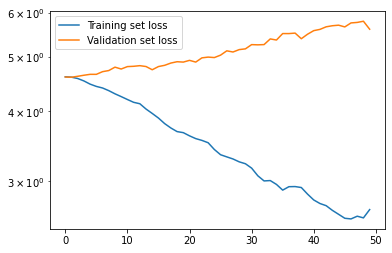

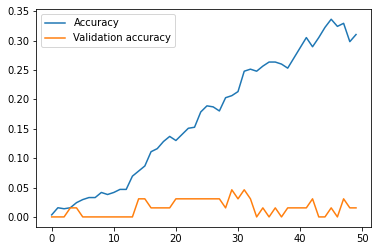

In [12]:
model.fit(X, y, epochs=50, batch_size=64, validation_split = 0.1, shuffle = True)

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(["Training set loss", "Validation set loss"])
plt.yscale("log")
plt.show()

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend([ "Accuracy", "Validation accuracy"])

plt.show()

In [13]:
y_pred = model.predict(X)         
y_pred = np.argmax(y_pred, axis = 1)

21/21 [==============================] - 6s 239ms/step


In [14]:
print("F1 score : ", f1_score(y_, y_pred, average = 'weighted'))
print("Accuracy : ", accuracy_score(y_, y_pred))
print("Precision score : ", precision_score(y_, y_pred, average = 'weighted'))
print("Recall score : ", recall_score(y_, y_pred, average = 'weighted'))

F1 score :  0.27578079502545516
Accuracy :  0.2803738317757009
Precision score :  0.3604921206820513
Recall score :  0.2803738317757009


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
model.save("model")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


### Training only with hands landmarks

In [24]:
X2 = X[:,:,:42]

In [25]:
input_dim_2 = X2.shape[1:]

In [27]:
model2 = Sequential()
model2.add(Input(shape=(input_dim_2)))
model2.add(Conv2D(filters=8, kernel_size= 3, strides = (1, 2), padding='same', activation='relu'))
model2.add(Conv2D(filters=16, kernel_size=(input_dim[0], 3), strides = (1, 2), padding='same', activation='relu'))
model2.add(Conv2D(filters=32, kernel_size= 3, strides = (1, 2),padding='same', activation='relu'))
model2.add(tf.keras.layers.Reshape((100, 6*32)))
model2.add(LSTM(64))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(nb_classes, activation='softmax'))
model2.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 21, 8)        224       
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 11, 16)       38416     
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 6, 32)        4640      
                                                                 
 reshape_1 (Reshape)         (None, 100, 192)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                65792     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 1030)             

In [31]:
for train_index, test_index in sss.split(X2, y_):
    X_train, X_test = X2[train_index], X2[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
    
    plt.plot(model2.history.history['loss'])
    plt.plot(model2.history.history['val_loss'])
    plt.plot(model2.history.history['accuracy'])
    plt.plot(model2.history.history['val_accuracy'])
    plt.legend(["Training set loss", "Validation set loss", "Accuracy", "Validation accuracy"])

    plt.yscale("log")
    plt.show()

Epoch 1/10
44/44 [==============================] - 41s 809ms/step - loss: 6.9529 - accuracy: 0.0014 - val_loss: 6.9421 - val_accuracy: 0.0017
Epoch 2/10
21/44 [=============>................] - ETA: 15s - loss: 6.8705 - accuracy: 0.0037


KeyboardInterrupt



In [56]:
y_pred = model2.predict(X2)         
y_pred = np.argmax(y_pred, axis = 1)

125/125 [==============================] - 8s 59ms/step


In [57]:
print("F1 score : ", f1_score(y_, y_pred, average = 'weighted'))
print("Accuracy : ", accuracy_score(y_, y_pred))
print("Precision score : ", precision_score(y_, y_pred, average = 'weighted'))
print("Recall score : ", recall_score(y_, y_pred, average = 'weighted'))

F1 score :  0.19501868653081791
Accuracy :  0.16930419492589802
Precision score :  0.3207483299904223
Recall score :  0.16930419492589802


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Less complicated architecture

In [80]:
model = Sequential()
model.add(Input(shape=(input_dim)))
model.add(tf.keras.layers.Reshape((100, 520*3)))
model.add(LSTM(128))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [81]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_11 (Reshape)        (None, 100, 1560)         0         
                                                                 
 lstm_6 (LSTM)               (None, 128)               864768    
                                                                 
 dense_12 (Dense)            (None, 1030)              132870    
                                                                 
Total params: 997,638
Trainable params: 997,638
Non-trainable params: 0
_________________________________________________________________


In [82]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=1)

In [83]:
for train_index, test_index in sss.split(X, y_):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
    
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.legend(["Training set loss", "Validation set loss", "Accuracy", "Validation accuracy"])

    plt.yscale("log")
    plt.show()

Epoch 1/10
44/44 [==============================] - 29s 504ms/step - loss: 6.9783 - accuracy: 3.5894e-04 - val_loss: 6.9394 - val_accuracy: 0.0033
Epoch 2/10
44/44 [==============================] - 19s 439ms/step - loss: 6.9060 - accuracy: 0.0036 - val_loss: 6.9440 - val_accuracy: 0.0000e+00
Epoch 3/10
44/44 [==============================] - 16s 368ms/step - loss: 6.8546 - accuracy: 0.0194 - val_loss: 6.9546 - val_accuracy: 8.3682e-04
Epoch 4/10
44/44 [==============================] - 15s 335ms/step - loss: 6.7831 - accuracy: 0.0327 - val_loss: 6.9736 - val_accuracy: 0.0025
Epoch 5/10
44/44 [==============================] - 15s 344ms/step - loss: 6.7061 - accuracy: 0.0456 - val_loss: 7.0020 - val_accuracy: 0.0033
Epoch 6/10
 3/44 [=>............................] - ETA: 11s - loss: 6.6015 - accuracy: 0.0521


KeyboardInterrupt



In [31]:
y_pred = model.predict(X)         
y_pred = np.argmax(y_pred, axis = 1)

125/125 [==============================] - 36s 282ms/step


In [32]:
print("F1 score : ", f1_score(y_, y_pred, average = 'weighted'))
print("Accuracy : ", accuracy_score(y_, y_pred))
print("Precision score : ", precision_score(y_, y_pred, average = 'weighted'))
print("Recall score : ", recall_score(y_, y_pred, average = 'weighted'))

F1 score :  0.31895924822595473
Accuracy :  0.30419492589801556
Precision score :  0.41293071704964746
Recall score :  0.30419492589801556


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
